<a href="https://colab.research.google.com/github/rubyvanrooyen/data_processing/blob/master/3c39/notebooks/Comet_67P_occultation_track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comet 67P occultation track

## Library Installation

Use `skyfield` python package and published data files downloaded from the Minor Planet Center.    
https://rhodesmill.org/skyfield/kepler-orbits.html

In [ ]:
!pip install skyfield

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 5.4 MB/s 
     |████████████████████████████████| 228 kB 44.2 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 


Skyfield loads orbital elements from text files using the Pandas library.

In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install spectral-cube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 218 kB 5.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 74 kB 2.4 MB/s 


## Comet target definition
Use Skyfield to map comet ephemeris to sky coordinates given date of interest

In [ ]:
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.api import load, Topos
from skyfield.api import S, E, wgs84
from skyfield.data import mpc

In [ ]:
comet_name = '67P/Churyumov-Gerasimenko'

Build a dataframe of comets

In [ ]:
with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)
# Keep only the most recent orbit for each comet,
# and index by designation for fast lookup.
comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

print(len(comets), 'comets loaded')
print(mpc.COMET_URL)

[#################################] 100% CometEls.txt


962 comets loaded
https://www.minorplanetcenter.net/iau/MPCORB/CometEls.txt


Read ephemeris of selected comet.    
Cometary orbits are measured centered on the Sun.

You will therefore need to add the barycenter->Sun vector to the Sun->comet vector to produce a position that you can pass to the `observe()` method, which always measures positions from the Solar System barycenter.

In [ ]:
ts = load.timescale()
eph = load('de421.bsp')
sun, earth = eph['sun'], eph['earth']

ephem = comets.loc[comet_name]
print(ephem)
comet = sun + mpc.comet_orbit(ephem, ts, GM_SUN)
print(comet)

[#################################] 100% de421.bsp


designation                            67P/Churyumov-Gerasimenko
perihelion_year                                             2021
perihelion_month                                              11
perihelion_day                                            2.0956
perihelion_distance_au                                  1.210561
eccentricity                                            0.649809
argument_of_perihelion_degrees                           22.1463
longitude_of_ascending_node_degrees                      36.3295
inclination_degrees                                       3.8718
magnitude_g                                                 11.0
magnitude_k                                                  4.0
reference                                          MPEC 2022-PB4
Name: 67P/Churyumov-Gerasimenko, dtype: object
Sum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
 _KeplerOrbit 10 SUN -> str


## Load fits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename='/content/drive/MyDrive/Research Collaborations and Projects/Science Proposals/Comet 67P OH maser/images/target-3c39.fits'

In [ ]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils import data

import matplotlib.pyplot as plt

In [ ]:
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header).celestial
print(hdu.data.shape)
print(hdu.data.squeeze().shape)

Set OBSGEO-B to   -30.713200 from OBSGEO-[XYZ].
Set OBSGEO-H to     1046.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -30.713200 from OBSGEO-[XYZ].
Set OBSGEO-H to     1046.994 from OBSGEO-[XYZ]'.


(1, 1, 309, 310)
(309, 310)


## MeerKAT observer definition

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, AltAz
from astropy.coordinates import Longitude, Latitude, EarthLocation
from astropy.time import Time

import numpy as np

Topocentric coordinates specific to MeerKAT telescope's location on the Earth’s surface

In [ ]:
location = EarthLocation.from_geocentric(x=hdu.header['OBSGEO-X'],
                                         y=hdu.header['OBSGEO-Y'],
                                         z=hdu.header['OBSGEO-Z'],
                                         unit=u.m)
lat = f"{np.abs(location.lat.deg):.4f} S" if location.lat.deg < 0 else f"{location.lat.deg:.4f} N"
lon = f"{np.abs(location.lon.deg):.4f} W" if location.lon.deg < 0 else f"{location.lon.deg:.4f} E"
# Apparent topocentric position
meerkat = earth + Topos(lat, lon)

## Read time information from observation file

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 1627186165_sdp_l0-3c39-corr_timestamps.csv to 1627186165_sdp_l0-3c39-corr_timestamps.csv


In [ ]:
tsfile = '1627186165_sdp_l0-3c39-corr_timestamps.csv'
with open(tsfile, 'r') as fin:
    data = fin.readlines()

epoch = 3506716800.
timestamps = []
for ts_ in data:
    timestamps.append(float(ts_.strip()) - epoch)
timestamps = np.array(timestamps)

## Comet orbit calculation

In [ ]:
sky_dates = []
sky_coords = []
world_coords = []
for ts_ in timestamps:
    t = ts.from_astropy(Time(ts_, format='unix'))
    sky_dates.append(t.utc_datetime())
    # Apparent topocentric position
    apparent = meerkat.at(t).observe(comet).apparent()
    ra, dec, distance = apparent.radec()
    coords = SkyCoord(ra.hours*u.hour, dec.degrees*u.degree, frame='icrs')
 #    print(coords)
    world_coords.append([coords.ra.deg, coords.dec.deg])
    sky_coords.append(coords)
#    sky_coords.append(SkyCoord(ra.hours*u.hour, dec.degrees*u.degree, frame='icrs'))
#    break

In [ ]:
def create_target(name, skycoord):
    ra_hms = skycoord.ra.hms
    ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
    dec_dms = skycoord.dec.dms
    dec_str = f'{int(dec_dms[0])}:{int(dec_dms[1])}:{dec_dms[2]:.3f}'

    tgt_str = f'{name}, {skycoord.ra}, {skycoord.dec}, radec target, {ra_str}, {dec_str}'
    return tgt_str

for cnt, dt in enumerate(sky_dates):
    print(f"On {dt} {create_target('67P', sky_coords[cnt])}")

On 2021-07-25 04:20:47.379998+00:00 67P, 20.19480586533073 deg, 3.7048865628403274 deg, radec target, 1:20:46.753, 3:42:17.592
On 2021-07-25 04:20:55.849998+00:00 67P, 20.194860401522522 deg, 3.7049083760329005 deg, radec target, 1:20:46.766, 3:42:17.670
On 2021-07-25 04:21:04.309981+00:00 67P, 20.19491487366768 deg, 3.704930163557628 deg, radec target, 1:20:46.780, 3:42:17.749
On 2021-07-25 04:21:12.779981+00:00 67P, 20.194969410099464 deg, 3.704951976683516 deg, radec target, 1:20:46.793, 3:42:17.827
On 2021-07-25 04:21:21.249981+00:00 67P, 20.195023946651936 deg, 3.7049737897760417 deg, radec target, 1:20:46.806, 3:42:17.906
On 2021-07-25 04:21:29.719982+00:00 67P, 20.19507848365627 deg, 3.7049956029973585 deg, radec target, 1:20:46.819, 3:42:17.984
On 2021-07-25 04:21:38.180004+00:00 67P, 20.195132956212582 deg, 3.7050173903302905 deg, radec target, 1:20:46.832, 3:42:18.063
On 2021-07-25 04:21:46.650005+00:00 67P, 20.19518749346026 deg, 3.70503920348493 deg, radec target, 1:20:46.8

## Display overlap

In [ ]:
comet_world = np.array(world_coords, dtype=np.float64)
comet_pixcrd = wcs.wcs_world2pix(comet_world, 0)
comet_pixcrd = np.asarray(comet_pixcrd, dtype=int)

_3c39_ = SkyCoord('01h21m00.048s', '+03d44m20.72s', frame='icrs')
# Convert the same coordinates back to pixel coordinates.
world = np.array([[_3c39_.ra.degree, _3c39_.dec.degree]], dtype=np.float64)
pixcrd = wcs.wcs_world2pix(world, 0)
pixcrd = np.asarray(pixcrd, dtype=int)

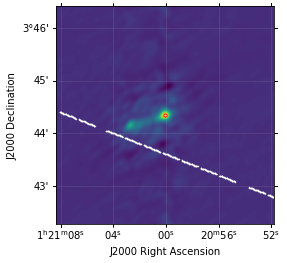

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(1, 1, 1, projection=wcs)
ax.imshow(hdu.data.squeeze(), origin='lower') 
ax.get_transform('icrs')
ax.grid(color='white', alpha=0.1, linestyle='solid')

# The following line makes it so that the zoom level no longer changes,
# otherwise Matplotlib has a tendency to zoom out when adding overlays.
ax.set_autoscale_on(False)
ax.scatter(comet_pixcrd[:,0], comet_pixcrd[:,1], s=0.1, edgecolor='white', facecolor=(1, 1, 1, 0.5))
ax.scatter(pixcrd[:,0], pixcrd[:,1], s=10, edgecolor='red', facecolor=(1, 1, 1, 0.5))

ra = ax.coords[0]
dec = ax.coords[1]
ra.set_axislabel('J2000 Right Ascension')
dec.set_axislabel('J2000 Declination')

plt.savefig('comet_track.png', dpi=300)
plt.show()